# <center>Predicting the Bike Rental</center>
<div>
<img src="Data/Bike_Rental.jpg" width="400"/>
</div>

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which is what we work with in this project. The file contains <mark>17380</mark> rows, with each row representing the number of bike rentals for a single hour of a single day.

Here are the descriptions for the relevant columns:

- <mark>instant</mark> - A unique sequential ID number for each row
- <mark>dteday</mark> - The date of the rentals
- <mark>season</mark> - The season in which the rentals occurred
- <mark>yr</mark> - The year the rentals occurred
- <mark>mnth</mark> - The month the rentals occurred
- <mark>hr</mark> - The hour the rentals occurred
- <mark>holiday</mark> - Whether or not the day was a holiday
- <mark>weekday</mark> - The day of the week (as a number, 0 to 7)
- <mark>workingday</mark> - Whether or not the day was a working day
- <mark>weathersit</mark> - The weather (as a categorical variable)
- <mark>temp</mark> - The temperature, on a 0-1 scale
- <mark>atemp</mark> - The adjusted temperature
- <mark>hum</mark> - The humidity, on a 0-1 scale
- <mark>windspeed</mark> - The wind speed, on a 0-1 scale
- <mark>casual</mark> - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- <mark>registered</mark> - The number of registered riders (people who had already signed up)
- <mark>cnt</mark> - The total number of bike rentals (casual + registered)

## Project Goals

In this project, we will try to predict the total number of bikes people rented in a given hour. We will predict the <mark>cnt</mark> column using all of the other columns, except for <mark>casual</mark> and <mark>registered</mark>. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

We will compare the use of a <mark>Linear Regression</mark> algorith and a <mark>Decision Tree</mark> algorithm and discuss why significant differences can occur.

# Importing Libraries

In [1]:
# Standard Python libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime as dt

# Machine learning libraries and tools
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Dealing with warnings and presentation of dataframes
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 99

# Reading in the Dataset

The data is stored in a csv file <mark>bike_rental_hour.csv</mark>.

In [2]:
# Reading in the data.
rental_data = pd.read_csv('./Data/bike_rental_hour.csv')

# Exploring the Dataset

In [3]:
# Looking at the data structure using head()
rental_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The most rentals at any one time is: 977


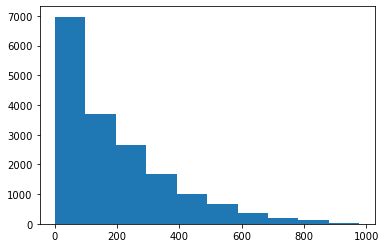

In [4]:
# Plotting a histogram of the total number of hired bikes at any one time.
plt.hist(rental_data['cnt'])

# Finding the maximum number of bike rentals at any one time
print("The most rentals at any one time is: " + str(rental_data['cnt'].max()))

# Observations

We can see that most frequently there are between 0 and 100 bike rentals at any one time. the most concurrrent bike rentals at any one time is 977.

Next we are going to look at what factors have the strongest correlation with the concurrent number of bike rentals:

In [5]:
# Finding the correlation of different variables with the concurrent bike rentals
rental_data.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

# Observations

Ignoring the registration types (<mark>casual</mark> and <mark>registered</mark>), we can see that the factor with the strongest correlation to bike rentals is the <mark>temp</mark> (temperature), which has a postitive correlation coeffecient of <mark>0.404</mark>. This makes sense as people are more likely to hire bikes when the temperature favours biking / being active outdoors. People will tend to avoid biking when it is too cold or extremely hot. This ties in with <mark>hum</mark>, <mark>weathersit</mark>, and <mark>season</mark>, which will have influence on the temperature and weather conditions that are favourable for biking.

Another strong correlation is <mark>hr</mark> (time of day), with a positive correlation coeffecient of <mark>0.394</mark>. Bikes are more likely to be hired during the daylight hours, when it is safer to bike, and also around business hours when people are going about the daily routines.


# Creating Data Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

The <mark>hr</mark> column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We are going to introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

We will do this by creating a function that takes the numeric hour value and classify it as morning (<mark>1</mark>), afternoon (<mark>2</mark>), evening (<mark>3</mark>), or night (<mark>4</mark>).

In [6]:
# Defining function to convert 24 hour time into a category (morning 1, afternoon 2, evening 3, or night 4)

def assign_label(hour):
    if 6 <= hour < 12:
        return 1
    if 12 <= hour < 18:
        return 2
    if 18 <= hour < 24:
        return 3
    if 0 <= hour < 6:
        return 4

Applying this function to the data to generate a new categorised column representing the time of day (<mark>time_label</mark>).

In [7]:
# Applying function to the 'hr' column and assigning the categorised result to a new data column 'time_label'
rental_data['time_label'] = rental_data['hr'].apply(assign_label)

# Looking at the first 10 entries to see that the function has worked as expeceted
rental_data.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


# Partitioning into Training and Testing Datasets

Before we can begin applying machine learning algorithms, we need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set.

We are going to divide the data so that 80% of the dataset is in the training set, while the remaining 20% is in the test dataset. As this is continuous data, we do not want to do a straight split. Instead we will randomly sample the dataset, this will reduce bias in our data.

When evaluating the error of our machine learning algorithm, we are going to assess the fit based on mean squared error (<mark>MSE</mark>), which works well on continuous data.

In [8]:
# Creating a training dataset with 80% of the overall dataset
training = rental_data.sample(frac=0.8)

# We want the remaining data to be that which IS NOT in the training dataset
test = rental_data[~rental_data.index.isin(training.index)]

Checking that the total of the test and train datasets matches that of the overall dataset.

In [9]:
print("The combined length of the training and test datasets are: " + str(len(training)+len(test)))
print("The total length of the overall dataset is: " + str(len(rental_data)))

The combined length of the training and test datasets are: 17379
The total length of the overall dataset is: 17379


# Applying Linear Regression

We are first going to apply a linear regression to the data. Linear regression should work fairly well on this data, given that many of the columns are highly correlated with <mark>cnt</mark>.

We'll need to ignore the <mark>casual</mark> and <mark>registered</mark> columns because <mark>cnt</mark> is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (<mark>cnt</mark>), it doesn't make sense that we'd already know casual or registered, because those numbers are added together to get <mark>cnt</mark>.

In [10]:
# Creating a list of predictor columns to use in training and predictions.
predictors = list(rental_data.columns)

# We want to exclude some data, including casual, registered, cnt (target column), dteday
predictors.remove('dteday')
predictors.remove('cnt')
predictors.remove('registered')
predictors.remove('casual')

print(predictors)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


# Training and Testing the Linear Regression Model

In [11]:
# Instantiating the linear regression model
lr = LinearRegression()

# Fitting the model on the training dataset
lr.fit(training[predictors], training['cnt'])

# Predicting cnt values using the Linear Regression model we just fitted
cnt_predicted = lr.predict(test[predictors])

# Calculating the mean square error (MSE)
MSE = mean_squared_error(test['cnt'], cnt_predicted)

# Printing the MSE
print("The MSE value is: " + str(round((MSE),2)))

The MSE value is: 17919.92


# Observations

The error is very high. The answer may be found in the extreme range of values for <mark>cnt</mark> seen in the histogram plotted earlier. The data is right-skewed toward lower <mark>cnt</mark> values, with very few large numbers of concurrent bike rentals. The inability to predict these larger nubmers in the dataset are penalised with large <mark>MSE</mark> values.

# Applying a Decision Tree Algorithm

We're now ready to apply the decision tree algorithm. We'll be able to compare the decision tree algorithm error with the error from linear regression, which will enable us to pick the right algorithm for this dataset.

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability - small changes in the input data can result in a very different output model.

# Training and Testing the Decision Tree Model

In [12]:
# Instantiating the decision tree model
dt = DecisionTreeRegressor()

# Fitting the model on the training dataset
dt.fit(training[predictors], training['cnt'])

# Predicting cnt values using the Decision Tree model we just fitted
cnt_predicted = dt.predict(test[predictors])

# Calculating the mean square error (MSE)
MSE = mean_squared_error(test['cnt'], cnt_predicted)

# Printing the MSE
print("The MSE value is: " + str(round((MSE),2)))

The MSE value is: 3237.47


# Observations

We can see that we have had a six fold reduction in the <mark>MSE</mark> from the Linear Regression model. It is clear that the Decision Tree algorithm is doing a better job of predicting the <mark>cnt</mark> value. We are going to do some parameter testing to see if we can improve the model fit.

# Hyper parameterisation

We are going to look at the effect of changing the <mark>max_depth</mark>, <mark>min_samples_leaf</mark>, and <mark>min_samples_split</mark>. To do this we are going to write function for testing a range of values for each parameter.

In [13]:
# Defining a function to test a range of max_depth parameterisations
def test_tree_md(parameter_list):
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the max_depth from the instance called (i) from the input
        # parameter_list.
        dt = DecisionTreeRegressor(max_depth=i)
        
        # Fitting the model on the training dataset
        dt.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = dt.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Decision Tree, when using a max_depth of " + str(i) + " is: " + str(round((MSE),2)))

# Listing the parameters we want to test for max_depth
parameter_list = [1,5,10,50,100]

# Testing these parameter values with our function.
test_tree_md(parameter_list)

The MSE value of the trained Decision Tree, when using a max_depth of 1 is: 23702.46
The MSE value of the trained Decision Tree, when using a max_depth of 5 is: 12295.63
The MSE value of the trained Decision Tree, when using a max_depth of 10 is: 3578.11
The MSE value of the trained Decision Tree, when using a max_depth of 50 is: 3029.82
The MSE value of the trained Decision Tree, when using a max_depth of 100 is: 3245.95


In [14]:
# Defining a function to test a range of min_samples_leaf parameterisations
def test_tree_msl(parameter_list):
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the min_samples_leaf from the instance called (i) from the 
        # input parameter_list.
        dt = DecisionTreeRegressor(min_samples_leaf=i)
        
        # Fitting the model on the training dataset
        dt.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = dt.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Decision Tree, when using a min_samples_leaf of " 
              + str(i) + " is: " + str(round((MSE),2)))

# Listing the parameters we want to test for min_samples_leaf
parameter_list = [1,2,5,10,50]

# Testing these parameter values with our function.
test_tree_msl(parameter_list)

The MSE value of the trained Decision Tree, when using a min_samples_leaf of 1 is: 3296.88
The MSE value of the trained Decision Tree, when using a min_samples_leaf of 2 is: 3001.43
The MSE value of the trained Decision Tree, when using a min_samples_leaf of 5 is: 2718.39
The MSE value of the trained Decision Tree, when using a min_samples_leaf of 10 is: 2717.55
The MSE value of the trained Decision Tree, when using a min_samples_leaf of 50 is: 4255.01


In [15]:
# Defining a function to test a range of min_samples_split parameterisations
def test_tree_mss(parameter_list):
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the min_samples_split from the instance called (i) from the 
        # input parameter_list.
        dt = DecisionTreeRegressor(min_samples_split=i)
        
        # Fitting the model on the training dataset
        dt.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = dt.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Decision Tree, when using a min_samples_split of " + str(i) + " is: " + str(round((MSE),2)))

# Listing the parameters we want to test for min_samples_split
parameter_list = [2,5,10,50,100]

# Testing these parameter values with our function.
test_tree_mss(parameter_list)

The MSE value of the trained Decision Tree, when using a min_samples_split of 2 is: 3248.87
The MSE value of the trained Decision Tree, when using a min_samples_split of 5 is: 3079.51
The MSE value of the trained Decision Tree, when using a min_samples_split of 10 is: 2865.17
The MSE value of the trained Decision Tree, when using a min_samples_split of 50 is: 2968.46
The MSE value of the trained Decision Tree, when using a min_samples_split of 100 is: 3410.76


# Results

We can see that different parameterisations results in variations in the <mark>MSE</mark>. <mark>max_depth</mark> has the smalled <mark>MSE</mark> when using a depth of 10. <mark>min_samples_leaf</mark> has the lowest <mark>MSE</mark> when there are minimum of 5 samples per leaf. The optimal number for <mark>min_samples_split</mark> is 50.

However, these numbers have been derived in a very heurestic way. We could explore the parameterisation in a much more focussed way, but is beyond the scope of this project.

We can no use these optimal parameterisations in combination to see the result on the <mark>MSE</mark>

In [16]:
# Instantiating the decision tree model
dt = DecisionTreeRegressor(min_samples_split=50,min_samples_leaf=5,max_depth=10)

# Fitting the model on the training dataset
dt.fit(training[predictors], training['cnt'])

# Predicting cnt values using the Decision Tree model we just fitted
cnt_predicted = dt.predict(test[predictors])

# Calculating the mean square error (MSE)
MSE = mean_squared_error(test['cnt'], cnt_predicted)

# Printing the MSE
print("The MSE value is: " + str(round((MSE),2)))

The MSE value is: 3634.51


# Observations

We can see that even when usng the optimal parameters found through the hyper parameterisation, the <mark>MSE</mark> is still higher than that found with no parameterisation. It could be that in combination, the parameterisation are interferring with one another, or that we are preventing over-fitting to the training dataset.

# Applying a Random Forest Algorithm

We are finally going to apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [17]:
# Instantiating the random forest model
rf = RandomForestRegressor()

# Fitting the model on the training dataset
rf.fit(training[predictors], training['cnt'])

# Predicting cnt values using the Decision Tree model we just fitted
cnt_predicted = rf.predict(test[predictors])

# Calculating the mean square error (MSE)
MSE = mean_squared_error(test['cnt'], cnt_predicted)

# Printing the MSE
print("The MSE value is: " + str(round((MSE),2)))

The MSE value is: 1737.24


# Observations

We can see that the use of the Random Forest algorithm has greatly reduced the <mark>MSE</mark> over the use of just the Decision Tree algorithm.

# Hyper parameterisation

Again we can look at the effect of changing parameterisation. This time we are going to modify the the <mark>max_depth</mark>, <mark>min_samples_leaf</mark>, <mark>min_samples_split</mark>,<mark>max_features</mark> and <mark>n_estimators</mark>. 

The MSE value of the trained Random Forest, when using a max_depth of 1 is: 23702.18
The MSE value of the trained Random Forest, when using a max_depth of 5 is: 11824.23
The MSE value of the trained Random Forest, when using a max_depth of 10 is: 2615.93
The MSE value of the trained Random Forest, when using a max_depth of 50 is: 1742.05
The MSE value of the trained Random Forest, when using a max_depth of 100 is: 1707.57


Text(0.5, 0, 'min_samples_leaf')

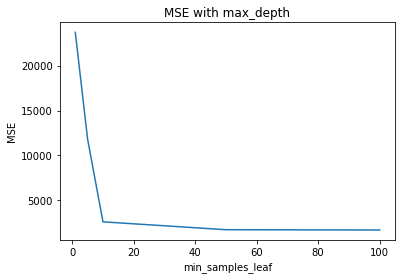

In [18]:
# Defining a function to test a range of max_depth parameterisations
def test_rf_md(parameter_list):
    prms = []
    mse_list = []
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the max_depth from the instance called (i) from the input
        # parameter_list.
        rf = RandomForestRegressor(max_depth=i)
        
        # Fitting the model on the training dataset
        rf.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = rf.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Random Forest, when using a max_depth of " + str(i) + " is: " + str(round((MSE),2)))
        prms.append(i)
        mse_list.append(MSE)
    return prms, mse_list

# Listing the parameters we want to test for max_depth
parameter_list = [1,5,10,50,100]

# Testing these parameter values with our function.
prms, mse_list = test_rf_md(parameter_list)

# Plotting the MSE with changing max_depth
plt.plot(prms,mse_list)
plt.title('MSE with max_depth')
plt.ylabel('MSE')
plt.xlabel('min_samples_leaf')

The MSE value of the trained Random Forest, when using a min_samples_leaf of 1 is: 1727.67
The MSE value of the trained Random Forest, when using a min_samples_leaf of 2 is: 1759.74
The MSE value of the trained Random Forest, when using a min_samples_leaf of 5 is: 1839.33
The MSE value of the trained Random Forest, when using a min_samples_leaf of 10 is: 2102.74
The MSE value of the trained Random Forest, when using a min_samples_leaf of 50 is: 3819.87


Text(0.5, 0, 'min_samples_leaf')

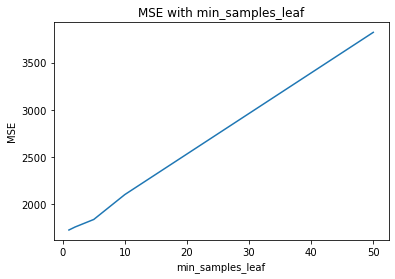

In [19]:
# Defining a function to test a range of min_samples_leaf parameterisations
def test_rf_msl(parameter_list):
    prms = []
    mse_list = []
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the min_samples_leaf from the instance called (i) from the
        # input parameter_list.
        rf = RandomForestRegressor(min_samples_leaf=i)
        
        # Fitting the model on the training dataset
        rf.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = rf.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Random Forest, when using a min_samples_leaf of " + str(i) + " is: " + str(round((MSE),2)))
        prms.append(i)
        mse_list.append(MSE)
    return prms, mse_list

# Listing the parameters we want to test for min_samples_leaf
parameter_list = [1,2,5,10,50]

# Testing these parameter values with our function.
prms, mse_list = test_rf_msl(parameter_list)

# Plotting the MSE with changing min_samples_split
plt.plot(prms,mse_list)
plt.title('MSE with min_samples_leaf')
plt.ylabel('MSE')
plt.xlabel('min_samples_leaf')

The MSE value of the trained Random Forest, when using a min_samples_split of 2 is: 1737.75
The MSE value of the trained Random Forest, when using a min_samples_split of 5 is: 1782.49
The MSE value of the trained Random Forest, when using a min_samples_split of 10 is: 1820.49
The MSE value of the trained Random Forest, when using a min_samples_split of 50 is: 2421.28
The MSE value of the trained Random Forest, when using a min_samples_split of 100 is: 3175.75


Text(0.5, 0, 'min_samples_split')

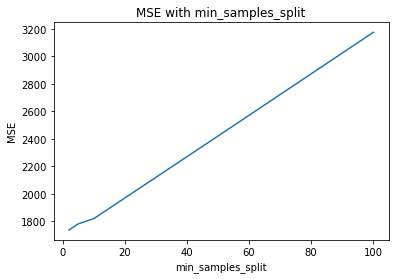

In [20]:
# Defining a function to test a range of min_samples_split parameterisations
def test_rf_mss(parameter_list):
    prms = []
    mse_list = []
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the min_samples_split from the instance called (i) from the
        # input parameter_list.
        rf = RandomForestRegressor(min_samples_split=i)
        
        # Fitting the model on the training dataset
        rf.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = rf.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Random Forest, when using a min_samples_split of " + str(i) + " is: " + str(round((MSE),2)))
        prms.append(i)
        mse_list.append(MSE)
    return prms, mse_list

# Listing the parameters we want to test for min_samples_split
parameter_list = [2,5,10,50,100]

# Testing these parameter values with our function.
prms, mse_list = test_rf_mss(parameter_list)

# Plotting the MSE with changing min_samples_split
plt.plot(prms,mse_list)
plt.title('MSE with min_samples_split')
plt.ylabel('MSE')
plt.xlabel('min_samples_split')

The MSE value of the trained Random Forest, when using a max_features of 2 is: 4502.68
The MSE value of the trained Random Forest, when using a max_features of 4 is: 2559.0
The MSE value of the trained Random Forest, when using a max_features of 6 is: 1795.39
The MSE value of the trained Random Forest, when using a max_features of 8 is: 1629.36
The MSE value of the trained Random Forest, when using a max_features of 10 is: 1645.17


Text(0.5, 0, 'max_features')

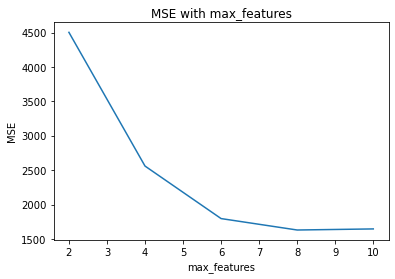

In [21]:
# Defining a function to test a range of max_features parameterisations
def test_rf_mf(parameter_list):
    prms = []
    mse_list = []
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the max_features from the instance called (i) from the input
        # parameter_list.
        rf = RandomForestRegressor(max_features=i)
        
        # Fitting the model on the training dataset
        rf.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = rf.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Random Forest, when using a max_features of " + str(i) + " is: " + str(round((MSE),2)))
        prms.append(i)
        mse_list.append(MSE)
    return prms, mse_list

# Listing the parameters we want to test for max_features
parameter_list = [2,4,6,8,10]

# Testing these parameter values with our function.
prms, mse_list = test_rf_mf(parameter_list)

# Plotting the MSE with changing n_estimators
plt.plot(prms,mse_list)
plt.title('MSE with max_features')
plt.ylabel('MSE')
plt.xlabel('max_features')

The MSE value of the trained Random Forest, when using a n_estimators of 1 is: 4225.92
The MSE value of the trained Random Forest, when using a n_estimators of 5 is: 2191.57
The MSE value of the trained Random Forest, when using a n_estimators of 10 is: 1964.02
The MSE value of the trained Random Forest, when using a n_estimators of 50 is: 1727.38
The MSE value of the trained Random Forest, when using a n_estimators of 100 is: 1732.79


Text(0.5, 0, 'n_estimators')

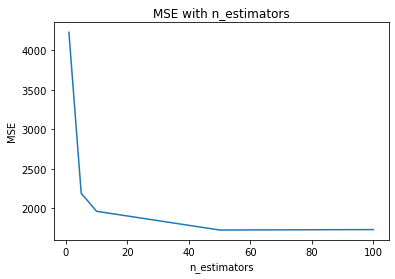

In [22]:
# Defining a function to test a range of n_estimators parameterisations
def test_rf_ne(parameter_list):
    prms = []
    mse_list = []
    for i in parameter_list:
        # Instantiating the decision tree model, we are specifying the n_estimators from the instance called (i) from the input
        # parameter_list.
        rf = RandomForestRegressor(n_estimators=i)
        
        # Fitting the model on the training dataset
        rf.fit(training[predictors], training['cnt'])
        
        # Predicting cnt values using the Decision Tree model we just fitted
        cnt_predicted = rf.predict(test[predictors])
        
        # Calculating the mean square error (MSE)
        MSE = mean_squared_error(test['cnt'], cnt_predicted)
        
        # Printing the MSE
        print("The MSE value of the trained Random Forest, when using a n_estimators of " + str(i) + " is: " + str(round((MSE),2)))
        prms.append(i)
        mse_list.append(MSE)
    return prms, mse_list

# Listing the parameters we want to test for n_estimators
parameter_list = [1,5,10,50,100]

# Testing these parameter values with our function.
prms, mse_list = test_rf_ne(parameter_list)

# Plotting the MSE with changing n_estimators
plt.plot(prms,mse_list)
plt.title('MSE with n_estimators')
plt.ylabel('MSE')
plt.xlabel('n_estimators')

# Observations

We observe the similar <mark>MSE</mark> values for the hyper parameterisation of <mark>max_depth</mark>, <mark>min_samples_leaf</mark>, and <mark>min_samples_split</mark>, which is to be expected. 

The new parameters tested pertain to the number of features used to train the model on (<mark>max_features</mark>) and the number of decision tree ensembles tested (<mark>n_estimators</mark>). We see that in both instances, the more features used and the number of ensembles tested, the lower the final <mark>MSE</mark> value.

Again, we can see that the parameterised <mark>MSE</mark> is still higher or similar to that found with no parameterisation. It could be that in combination, the parameterisation are interferring with one another, or that we are preventing over-fitting to the training dataset.